# Solow Model
## Andres Perez (Worked with group)
(5/5)

This assignment is difficult.  We will only have a little time to cover the Solow model in lecture, and the assignment is really about making a class that computes its steady state for any country from the data in the Penn World Table.  If you can write the code for any class that actually works for some piece of this problem, I will give you full credit.

In [1]:
%matplotlib inline
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
# https://www.statsmodels.org/stable/regression.html
import datetime
import requests
import scipy.stats
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import pandas_datareader as pdr
from sympy import *
from fredapi import Fred
fred = Fred(api_key='6c0ecd6565503b64631fd2b36f71293a')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

This takes data from the Penn World Table and calculates the steady-state capital-labor ratio k defined implicitly by:

$$sf(k) = (n + g + ng + δ)k$$
     
The file pwt100.xlsx must be in the working directory. Its second sheet gives a list of the relevant macro variables

In [2]:
class Solow_residuals():
    
    def __init__(self, country = "USA", max_iter = 500, verbose = False, a = 1.0, b = 1_000_000.0, tol = 10e-5, A=1.0, ρ=0.04):
        self.country = country
        self.max_iter = max_iter
        self.verbose = verbose
        self.a = a
        self.b = b
        self.tol = tol
        self.A = A
        self.ρ = ρ
        
    def get_data(self):
        
        data = pd.read_excel('pwt100.xlsx',2)  
        self.df = data[data["countrycode"] == self.country]
        self.df.index=self.df['year'] 
        print("We are working with data from", self.df["country"][1950])
        
        
        self.y=self.df['rgdpna']/self.df['emp'] # GDP Per worker
        self.k=self.df['rnna']/self.df['emp'] # Capital Per worker
        self.tfp=self.df['rtfpna'] # Index of total factor productivity, 2017=1
        self.labor=self.df['emp']
        self.savings=self.df['csh_i']
        self.labor_share=self.df['labsh']
        
        return
    
    def preliminary(self):
    
        self.get_data()
        
        if self.verbose:
            
            plt.title('Logarithms of GDP and Capital per worker in '+self.country)
            plt.ylabel('log of 2017 US $ per worker')
            np.log(self.y).plot(color='blue')
            np.log(self.k).plot(color='red')
            plt.legend(['y','k'])
            plt.show()
        
            self.tfp.plot(color='blue')
            plt.title('TFP in '+self.country+', 2017=1')
            plt.ylabel('Index number')
            plt.show()
        
            self.savings.plot(color='blue')
            plt.title('Investment share in '+self.country)
            plt.ylabel('scalar')
            plt.show()
            
            self.labor_share.plot(color='blue')
            plt.title('Labor share in '+self.country)
            plt.ylabel('scalar')
            plt.show()
            
        return
    
    def tfp_regression(self):
            
        self.get_data()
        lhv=np.log(self.tfp.dropna())
        rhv=np.arange(len(lhv)) 
        rhv = sm.add_constant(rhv)
        lr = sm.OLS(lhv, rhv).fit()
        if self.verbose:
            print(lr.summary())
        self.g=lr.params[1] 
        print("The TFP growth rate for "+self.country+" is", np.around(self.g,3))
        self.resids=lhv-lr.predict(rhv) 
        
        if self.verbose:
            # Histogram of Error Terms
            plt.hist(self.resids, rwidth=0.95)
            plt.title('Error Terms', fontsize = 20) 
            plt.xlabel('Percent', fontsize = 18)
            plt.ylabel('Count', fontsize=18)
            plt.show()
        
            plt.title('Solow residuals', fontsize=20)
            plt.ylabel('Percentage deviations')
            self.resids.plot(color='blue')
            plt.show()
            
    
        lhv=np.log(self.labor.dropna())
        rhv=np.arange(len(lhv)) 
        rhv = sm.add_constant(rhv)
        lr = sm.OLS(lhv, rhv).fit()
        if self.verbose:
            print(lr.summary())
        self.n=lr.params[1] 
        print("The labor force growth rate for "+self.country+" is", np.around(self.n,3))
            
        
        return
    
    def compute_parameters(self):
        
        self.tfp_regression() 
        self.get_data() 
        self.δ=self.df['delta'].mean()
        self.s=self.df['csh_i'].mean()
        self.α=1-self.df['labsh'].mean()
        
        if self.verbose:
            print("The depreciation rate for "+self.country+" is", np.around(self.δ,3))
            print("The savings rate for "+self.country+" is", np.around(self.s,3))
            print("Capital's share for "+self.country+" is", np.around(self.α,3))
        
        return
    
    def intensive(self,x):
        
        if self.ρ == 0:
            f = lambda x: self.A*x**self.α # Cobb-Douglas
        else:
            f = lambda x: self.A*((self.α*x**self.ρ)+(1-self.α))**(1/self.ρ) # General case
        return f(x)
    
    def benchmark_TFP(self):
        
        self.A=self.y[2017]/self.intensive(self.k[2017]) 
        return
    
    def compare_data(self):
        
        self.compute_parameters()
        
        begin=np.argmax(np.isfinite(self.tfp))  # Returns First True Element
        tfp=self.tfp[self.tfp.index>=begin] 
        y=self.y[self.y.index>=begin]
        k=self.k[self.k.index>=begin]
        
        fit=[]
        start=-0.05
        incr=0.01
        stop=-start+incr
        grid=np.arange(start,stop,incr)

        for x in grid:
            self.A=1.0
            self.ρ=x
            self.benchmark_TFP()
            yhat=tfp*self.intensive(k)
            rmse=np.sqrt(((np.log(y)-np.log(yhat))**2).mean())
            fit.append(rmse)
        #print(fit)
        self.A=1.0
        self.ρ=grid[np.argmin(fit)]
        print('The best ρ is ', self.ρ)
        self.benchmark_TFP()
        yhat=tfp*self.intensive(k)
        rmse=np.sqrt(((np.log(y)-np.log(yhat))**2).mean())
            
        if self.verbose:
            plt.title('Logarithms of GDP per worker, data versus model '+self.country)
            plt.ylabel('log of 2017 US $ per worker')
            np.log(y).plot(color='blue')
            np.log(yhat).plot(color='red')
            plt.legend(['data','prediction'])
            plt.show()     
            
        rmse=np.sqrt(((np.log(y)-np.log(yhat))**2).mean())
        print("The root mean squared error is",np.around(rmse,4))
        return
    
    def solow(self,x):
        
        return (self.s*self.intensive(x) - x*(self.n+self.g+self.n*self.g+self.δ))
        
    def bisection(self): 
        
        f=self.solow
      
        if np.sign(f(self.a)) == np.sign(f(self.b)):
            raise Exception(
            "The scalars a and b do not bound a root")
        
        m = (self.a + self.b)/2
    
        if np.abs(f(m)) < self.tol:
            self.kbar=m
            return 
        
        elif np.sign(f(self.a)) == np.sign(f(m)):
            self.a=m
            return self.bisection()
        
        elif np.sign(f(self.b)) == np.sign(f(m)):
            self.b=m
            return self.bisection() 
        
    def steady_state(self):

        self.compare_data() 
        self.bisection()
        print("The steady-state k per efficiency unit of worker is", np.around(self.kbar,0))
        
        self.ybar=self.intensive(self.kbar)
        print("Steady-state GDP per efficiency unit of worker is", np.around(self.ybar,0))
        
        
            
        x = symbols('x')
        self.rbar=diff(self.intensive(x)).subs(x, self.kbar)  
        print("The steady-state rentals rate is", np.around(float(self.rbar),3))
        print("In steady state, capital's share is", np.around(float(self.rbar)*self.kbar/self.ybar,2))

        
        b=(1-self.δ+self.s*float(self.rbar))/(1+self.n+self.g+self.n*self.g)
        half_life= -np.log(2)/np.log(float(b))
        print("The half-life of the system in years is", np.around(float(half_life),1))
        return
    
    def compare_usa(self):
       
        self.tfp_regression()
                
        #These dates were chosen because they match the PWT TFP data
        start = datetime.datetime (1954, 1, 1)
        end = datetime.datetime (2019, 10, 1)
        var_names=['GDPC1']
        df_USA = pdr.DataReader(var_names,'fred',start,end)
        Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_USA['GDPC1']), 1600)
        df_USA["Y_Cycle"]=Y_cycle
        x=df_USA.groupby(df_USA.index.year)['Y_Cycle'].mean()
        
        if self.verbose:
            plt.title('Solow residuals',fontsize=20)
            plt.ylabel('Percentage deviations')
            x.plot(color="red")
            self.resids.plot(color='blue')
            plt.legend(['USA',self.country])
            plt.show()
        
        r=np.corrcoef(x, self.resids)[0,1]
        print('The correlation coefficient is', np.around(r,3))
        n=len(x)
        tstat=r*np.sqrt(n-2)/np.sqrt(1-r**2)
        print("The t statistic is", np.around(tstat,3)) 
        p_value=scipy.stats.t.sf(abs(tstat), df=n-2)
        print('Its p-value is', np.around(p_value,3))
        
        return

In [3]:
sr = Solow_residuals(country='MEX',verbose=True)

We are working with data from Mexico


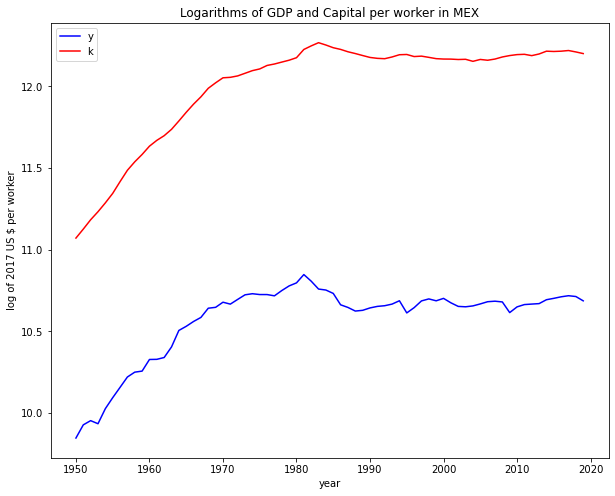

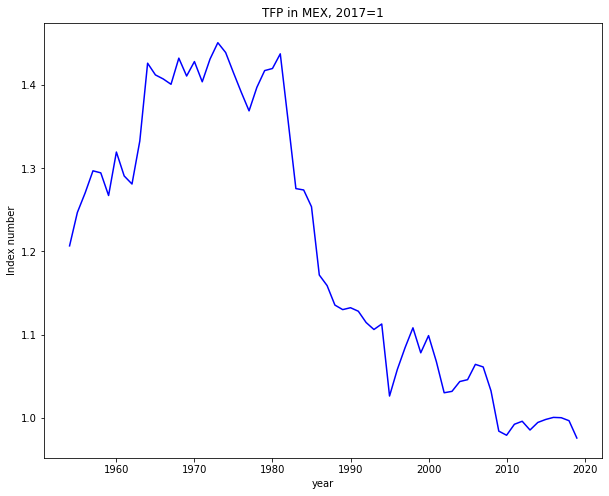

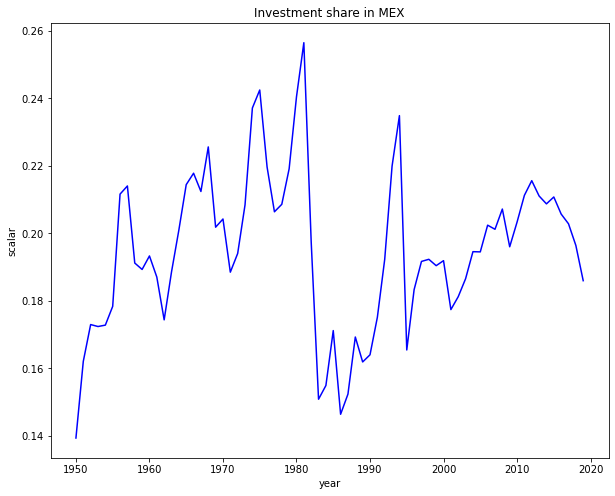

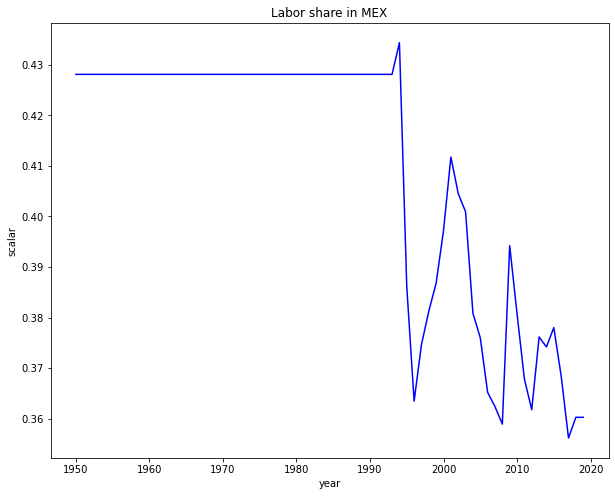

In [4]:
sr.preliminary()

We are working with data from Mexico
                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     176.1
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.89e-20
Time:                        17:50:34   Log-Likelihood:                 81.372
No. Observations:                  66   AIC:                            -158.7
Df Residuals:                      64   BIC:                            -154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

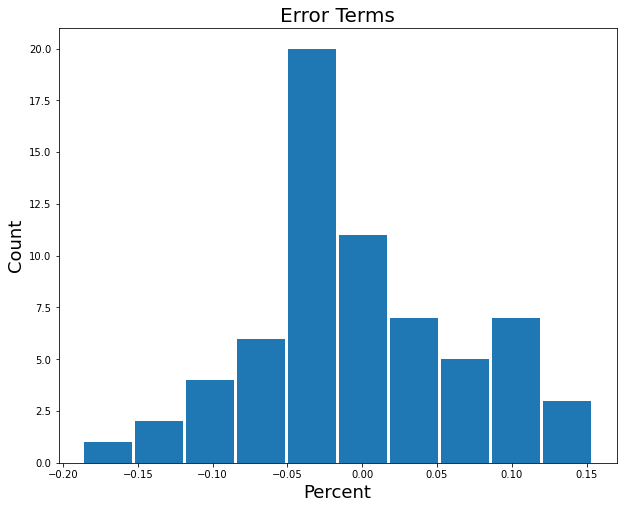

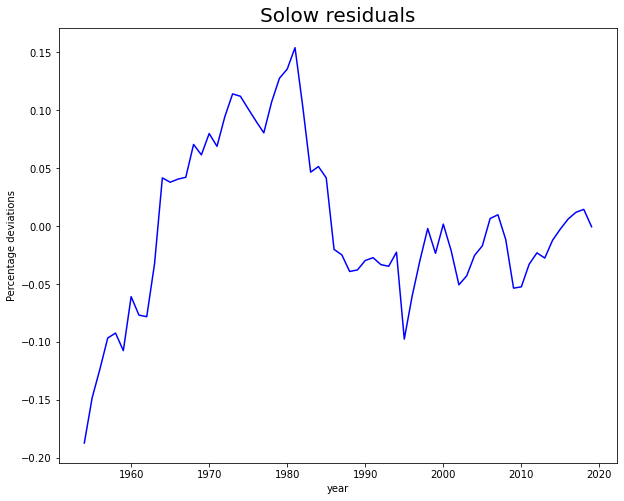

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4275.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.05e-63
Time:                        17:50:35   Log-Likelihood:                 76.340
No. Observations:                  70   AIC:                            -148.7
Df Residuals:                      68   BIC:                            -144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9601      0.020    100.462      0.0

In [5]:
sr.tfp_regression()

We are working with data from Mexico
                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     176.1
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.89e-20
Time:                        17:50:50   Log-Likelihood:                 81.372
No. Observations:                  66   AIC:                            -158.7
Df Residuals:                      64   BIC:                            -154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

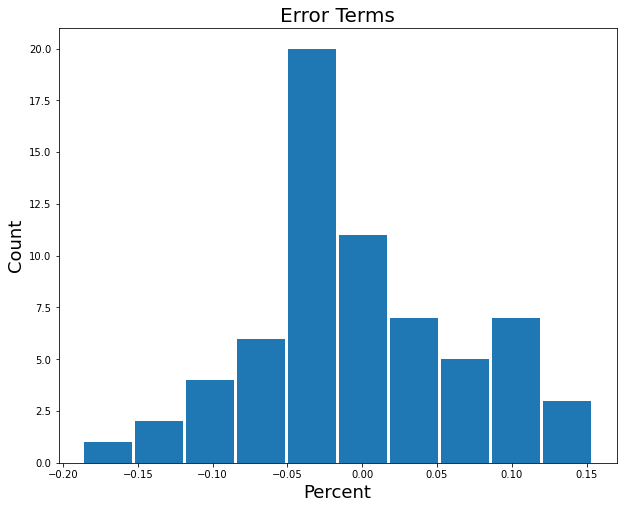

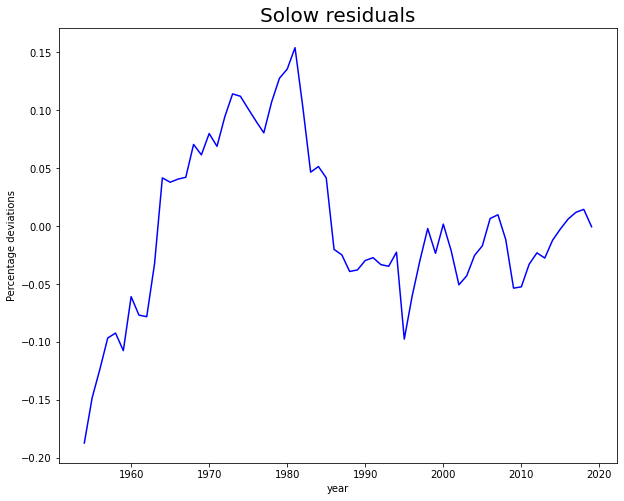

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4275.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.05e-63
Time:                        17:50:51   Log-Likelihood:                 76.340
No. Observations:                  70   AIC:                            -148.7
Df Residuals:                      68   BIC:                            -144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9601      0.020    100.462      0.0

In [6]:
sr.compute_parameters()

We are working with data from Mexico
                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     176.1
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.89e-20
Time:                        17:51:26   Log-Likelihood:                 81.372
No. Observations:                  66   AIC:                            -158.7
Df Residuals:                      64   BIC:                            -154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

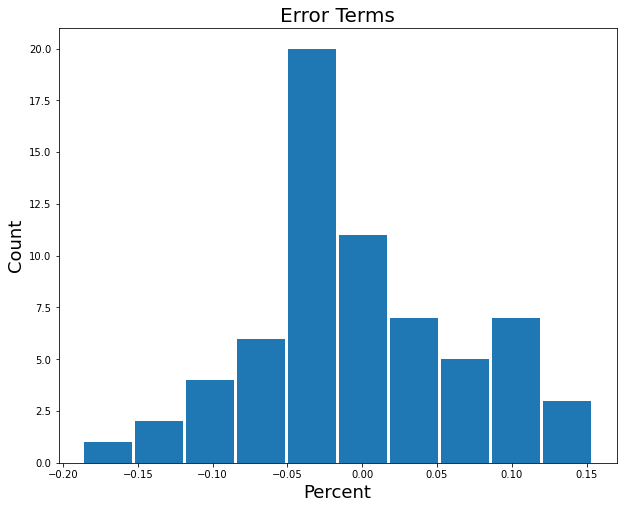

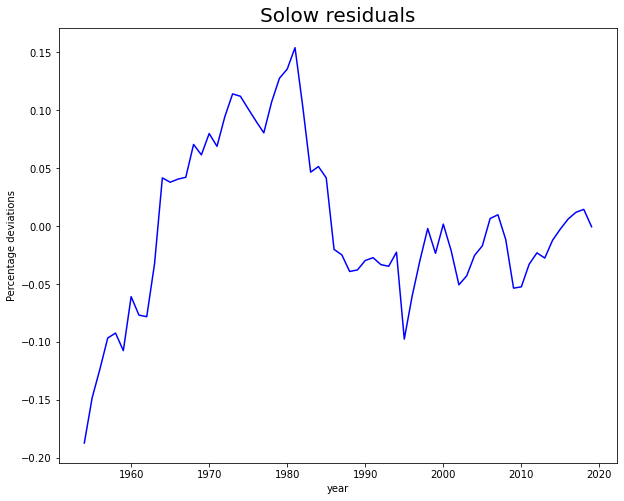

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4275.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.05e-63
Time:                        17:51:27   Log-Likelihood:                 76.340
No. Observations:                  70   AIC:                            -148.7
Df Residuals:                      68   BIC:                            -144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9601      0.020    100.462      0.0

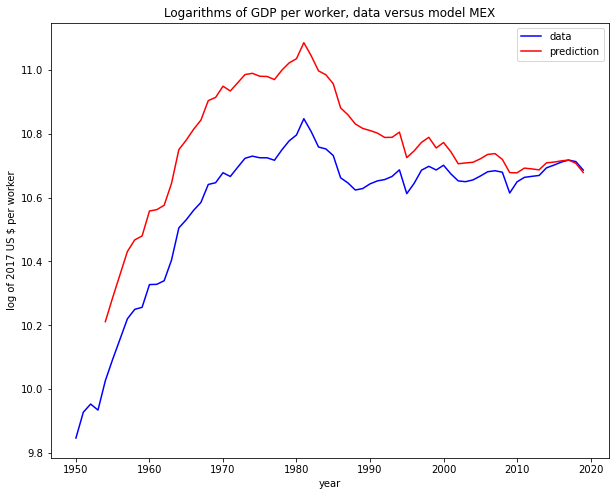

The root mean squared error is 0.1834


In [7]:
sr.benchmark_TFP()
sr.compare_data()

We are working with data from Mexico
                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     176.1
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.89e-20
Time:                        17:51:58   Log-Likelihood:                 81.372
No. Observations:                  66   AIC:                            -158.7
Df Residuals:                      64   BIC:                            -154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

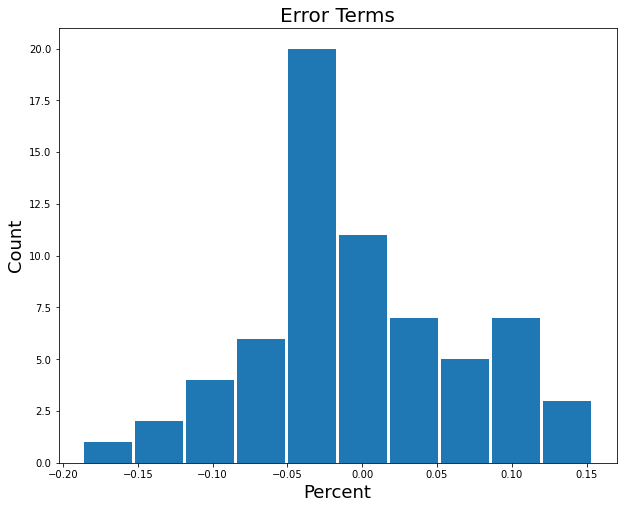

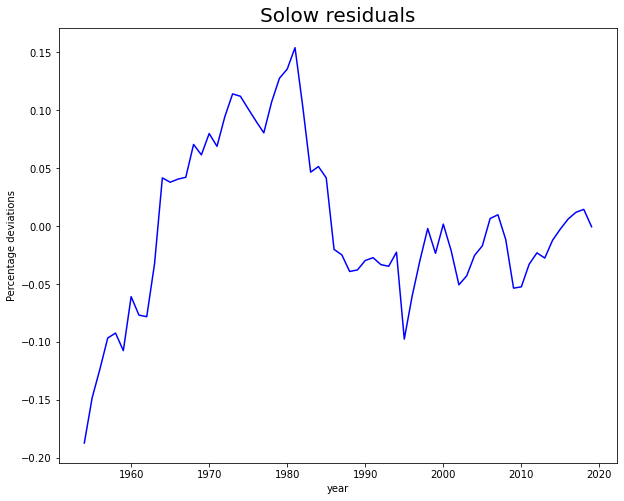

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4275.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.05e-63
Time:                        17:51:59   Log-Likelihood:                 76.340
No. Observations:                  70   AIC:                            -148.7
Df Residuals:                      68   BIC:                            -144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9601      0.020    100.462      0.0

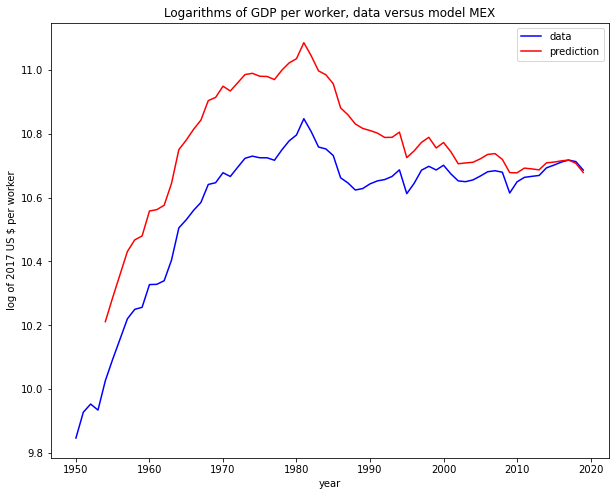

The root mean squared error is 0.1834
The steady-state k per efficiency unit of worker is 58026.0
Steady-state GDP per efficiency unit of worker is 17843.0
The steady-state rentals rate is 0.226
In steady state, capital's share is 0.74
The half-life of the system in years is 44.5


In [8]:
sr.bisection()
sr.steady_state()

We are working with data from Mexico
                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     176.1
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.89e-20
Time:                        17:52:33   Log-Likelihood:                 81.372
No. Observations:                  66   AIC:                            -158.7
Df Residuals:                      64   BIC:                            -154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

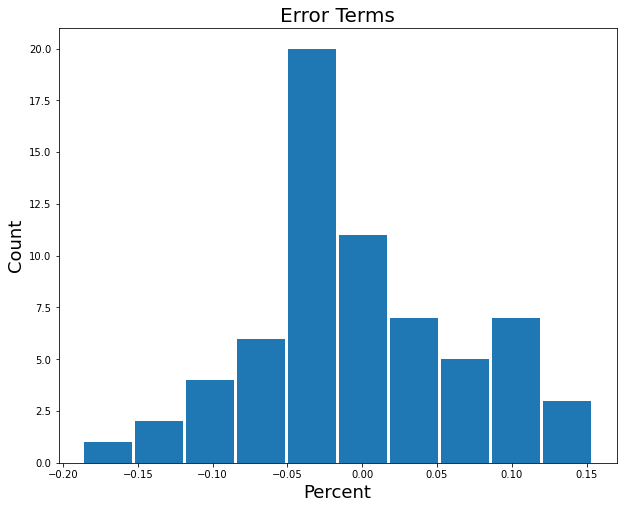

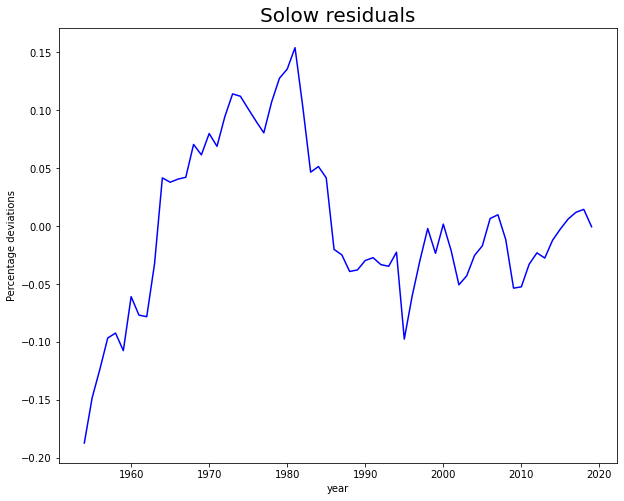

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4275.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.05e-63
Time:                        17:52:34   Log-Likelihood:                 76.340
No. Observations:                  70   AIC:                            -148.7
Df Residuals:                      68   BIC:                            -144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9601      0.020    100.462      0.0

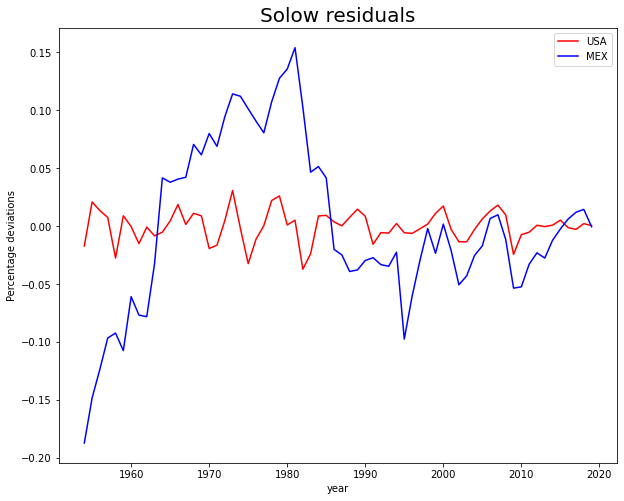

The correlation coefficient is 0.095
The t statistic is 0.761
Its p-value is 0.225


In [9]:
sr.compare_usa()